# Model Selection

In this project we analyze model complexity and discuss the bias-variance tradeoff .

In [4]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import griddata

The datafiles needed to complete this problem set are available on the course GitHub repository. We will use two datasets, the first is a labor force survey from Brazil (PNAD). An interesting introduction to this dataset can be found in the article D. Lam and RF Schoeni. (1993). "Effects of family background on earnings and returns to schooling: evidence from Brazil," _Journal of Political Economy_ 101 (4): 710 - 740.    

The second dataset is a consumption survey of a sample of rural households from Nicaragua. You can read more about this dataset in B. Graham and J. Powell. (2012). "Identification and estimation of average partial effects in `irregular’ correlated random coefficient panel data models," _Econometrica_ 80 (5): 2105 - 2152.

In [5]:
data = '/Users/simitiangreg/Documents/spring_23/Datasets/'
graphics = '/Users/simitiangreg/Documents/spring_23/Graphics/'

## Part 1: Analysis of Brazilian data

We will work with a PNAD subsample consisting of observations with positive monthly earnings. This allows us to define the outcome variable to be log monthly earnings, the distribution of which is well-approximated by the Gaussian distribution. We also just work with the population aged 20 to 65 years of age (prime working ages).

In [7]:
pnad96 = pd.read_csv(data + 'Brazil_1996PNAD_copy.out', header = 0, sep='\t+', engine='python')

# Find relevant estimation subsample
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)]

#Display the first few rows of the dataframe
sample.describe()

,AgeInDays,YRSSCH,MONTHLY_EARNINGS,Father_NoSchool,Father_Incomplete1stPrimary,Father_Complete1stPrimary,Father_Incomplete2ndPrimary,Father_Complete2ndPrimary,Father_IncompleteSecondary,Father_CompleteSecondary,...,Mother_NoSchool,Mother_Incomplete1stPrimary,Mother_Complete1stPrimary,Mother_Incomplete2ndPrimary,Mother_Complete2ndPrimary,Mother_IncompleteSecondary,Mother_CompleteSecondary,Mother_IncompleteHigher,Mother_CompleteHigher,Mother_DontKnow
count,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,...,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000
mean,37.971992,5.747324,632.051985,0.287575,0.205027,0.138419,0.033425,0.053685,0.052159,0.038802,...,0.341052,0.188288,0.134985,0.040849,0.064370,0.031951,0.044249,0.016392,0.052991,0.084873
std,11.126182,4.231994,1105.739430,0.452636,0.403725,0.345342,0.179746,0.225397,0.222349,0.193126,...,0.474067,0.390945,0.341710,0.197943,0.245413,0.175871,0.205650,0.126978,0.224018,0.278695
min,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.943190,3.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.750170,5.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.895960,8.000000,600.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.996570,15.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
sample.columns

Index(['AgeInDays', 'YRSSCH', 'MONTHLY_EARNINGS', 'Father_NoSchool',
       'Father_Incomplete1stPrimary', 'Father_Complete1stPrimary',
       'Father_Incomplete2ndPrimary', 'Father_Complete2ndPrimary',
       'Father_IncompleteSecondary', 'Father_CompleteSecondary',
       'Father_IncompleteHigher', 'Father_CompleteHigher', 'Father_DontKnow',
       'Mother_NoSchool', 'Mother_Incomplete1stPrimary',
       'Mother_Complete1stPrimary', 'Mother_Incomplete2ndPrimary',
       'Mother_Complete2ndPrimary', 'Mother_IncompleteSecondary',
       'Mother_CompleteSecondary', 'Mother_IncompleteHigher',
       'Mother_CompleteHigher', 'Mother_DontKnow'],
      dtype='object')

### Question 1
In a markdown box describe some basic features of our estimation sample. How many observations are available? Comment on any features of the distribution of school and/or earnings that stand out.

This next block of code shows how to use the *DecisionTreeRegressor* method in the machine learning module **sklearn**. For our initial analysis we will use just two predictors: years-of-schooling and age.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


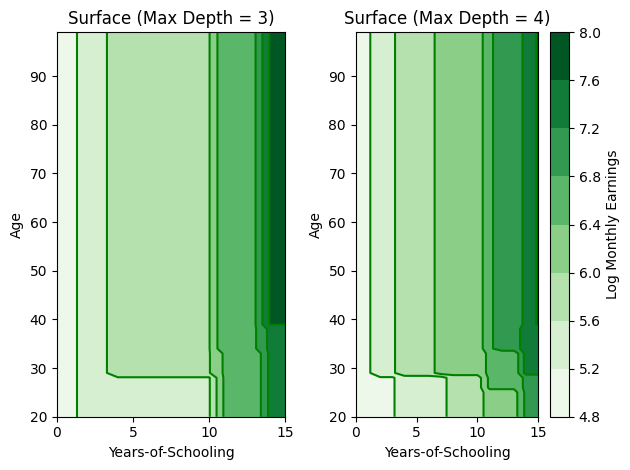

In [9]:
X = sample[['YRSSCH','AgeInDays']]
Y = np.log(sample['MONTHLY_EARNINGS'])

# Fit regression model
regr_1 = tree.DecisionTreeRegressor(max_depth=3)
regr_2 = tree.DecisionTreeRegressor(max_depth=4)
regr_1.fit(X, Y)
regr_2.fit(X, Y)

# Form interpolation grid upon which to plot estimated regression surface
Sch_i, Age_i = np.mgrid[0:16, 20:100]
Sch_i        = Sch_i.flatten('F')[:, np.newaxis]
Age_i        = Age_i.flatten('F')[:, np.newaxis]
X_i          = np.concatenate((Sch_i, Age_i ), axis=1)

y_1 = regr_1.predict(X_i)
y_2 = regr_2.predict(X_i)

Sch_i  = Sch_i.reshape((16, 80), order='F')
Age_i  = Age_i.reshape((16, 80), order='F')
y_1    = y_1.reshape((16, 80), order='F')
y_2    = y_2.reshape((16, 80), order='F')

# Create a 1 x 2 array of plots, with a contour representation of (i) the MLE regression surface
# as well as (ii) its smoothed USE counterpart.
plt.figure(1)
plt.subplot(121)
surf_1    = plt.contourf(Sch_i, Age_i, y_1, cmap='Greens')
surf_1_cl = plt.contour(surf_1,colors = 'Green')
plt.title('Surface (Max Depth = 3)')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Age')

plt.subplot(122)
surf_2    = plt.contourf(Sch_i, Age_i, y_2, cmap='Greens')
surf_2_cl = plt.contour(surf_2,colors = 'Green')
cb = plt.colorbar(surf_2)
cb.set_label('Log Monthly Earnings')
plt.title('Surface (Max Depth = 4)')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Age')

# Save result
plt.tight_layout()
plt.savefig(graphics + 'Fig_RegressionTreeExample.png')

$----------------------------------------------------------------------$

$\text{Answer 1:}$

$\text{We have 57651 observations. Our 3 continuous variables are Age, Schooling and Earnings. We also have 20 binary variables for relative's schooling. } \\ \text{These include: [noschool, dontknow], and [1stprimary, 2ndprimary, seconday, higher] as [complete / incomplete], for both parents.}\\ \\ \text{} \\ \text{By comparing means and medians, we can see there isn't too much skew in age and schooling,} \\ \text{but there exists a strong right skew for earnings, as the median is approximately half of the average. (320 vs 632)} \\ \text{This can also be seen by looking at the maximum value of earnings which is 50000, compared to the 75th percentile value of 600}$

$----------------------------------------------------------------------$

### Question 2
In a separate markdown box comment on the regression tree results presented in the two figures above. What do they suggest about the relationship between schooling and earnings in Brazil? The relationship between age and earnings?

$----------------------------------------------------------------------$

$\text{Answer 2: }$

$\text{The relationship between schooling and earnings in Brazil is an exponentially increasing relationship.} \\ \text{This can be seen by the fact that log earnings are linearly increasing with schooling, although the true relationship is hard to gauge from the coloring of this chart.}\\ \\ \text{} \\ \text{The relationship between age and earnings is almost negligible after age 30} \\ \text{This can be seen because as you go up the y-axis, there is little difference in shading} \\ \text{A single `step' for those with under 10 years of schooling shows that there is often an increase in earnings after 30, but not any afterward.}\\ \text{Only those with +10 years of schooling exhibit two major `steps', as seen by the changes of shading moving upward.}$

$----------------------------------------------------------------------$

### Question 3
This next block of code prints out the fitted depth 3 regression tree. Discuss any additional features of the relationship between earnings, schooling and age that seem relevant in light of figure. Place your answer in a markdown box below the figure.

[Text(0.5, 0.875, 'Highest Grade Complete <= 10.5\nsquared_error = 1.025\nsamples = 57651\nvalue = 5.86'),
 Text(0.25, 0.625, 'Highest Grade Complete <= 3.5\nsquared_error = 0.727\nsamples = 46956\nvalue = 5.61'),
 Text(0.125, 0.375, 'Highest Grade Complete <= 1.5\nsquared_error = 0.644\nsamples = 17944\nvalue = 5.247'),
 Text(0.0625, 0.125, 'squared_error = 0.618\nsamples = 10168\nvalue = 5.092'),
 Text(0.1875, 0.125, 'squared_error = 0.607\nsamples = 7776\nvalue = 5.448'),
 Text(0.375, 0.375, 'Age <= 28.957\nsquared_error = 0.645\nsamples = 29012\nvalue = 5.835'),
 Text(0.3125, 0.125, 'squared_error = 0.484\nsamples = 9446\nvalue = 5.554'),
 Text(0.4375, 0.125, 'squared_error = 0.667\nsamples = 19566\nvalue = 5.971'),
 Text(0.75, 0.625, 'Highest Grade Complete <= 13.5\nsquared_error = 0.864\nsamples = 10695\nvalue = 6.954'),
 Text(0.625, 0.375, 'Age <= 33.666\nsquared_error = 0.672\nsamples = 6810\nvalue = 6.636'),
 Text(0.5625, 0.125, 'squared_error = 0.567\nsamples = 2558\nvalue = 

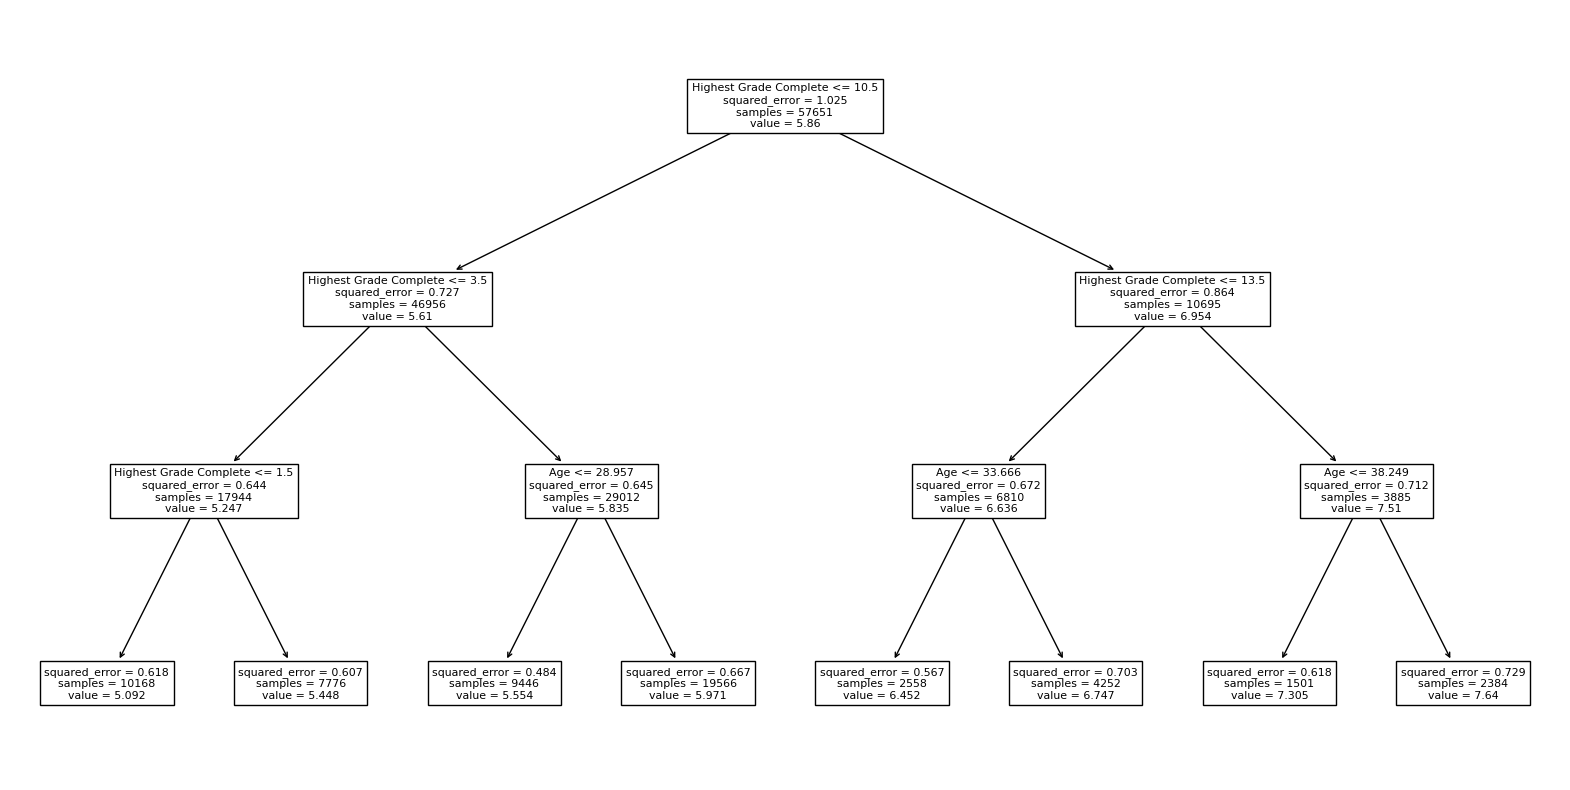

In [10]:
plt.figure(figsize=(20, 10))
tree.plot_tree(regr_1, feature_names = ['Highest Grade Complete', 'Age'])

$----------------------------------------------------------------------$

$\text{Answer 3: }$

$\text{The simplest first line draw in the depth 3 shading diagram is based purely off having LESS THAN 1.5 years of schooling. This results in log earnings BETWEEN 4.8 and 5.2.} \\ \text{\text{Those with 1.5 to 3.5 years of schooling fall into the next bucket, with log earnings between 5.2 and 5.6.}}\\ \text{Those with schooling between 3.5 to 10.5 years AND YOUNGER than 28.95 years exhibit log earnings BETWEEN 5.2 and 5.6 whereas}\\ \text{those with schooling BETWEEN 3.5 to 10.5 years AND OLDER than 28.95 years exhibit log earnings BETWEEN 5.6 and 6.0.}\\ \text{} \\ \text{Those with education ABOVE 13.5 AND OLDER than 38.249 display log earnings ABOVE 7.6} \\ \text{Those with education ABOVE 13.5 AND YOUNGER than 38.249 display log earnings BETWEEN 7.2 and 7.6} \\ \text{} \\ \text{The 5th and 6th leaves of the tree are less easy to see visually.}\\ \text{Essentially, for those with schooling between 10.5 and 13.5, a division is made for log earnings based on being older or younger than 33.6.} \\ \text{This is the weakest split, because we can see the shading around this area chnages significantly when we give our an additional layer to split on.}$

$----------------------------------------------------------------------$

### Question 4
The next block of code define a function which returns Ye's (1998) unbiased risk estimate for regression trees. Add a decription to this function. This description should define each of the function's six parameters as well as its three outputs. Add comments to the function which describe the operations made by the different blocks of code within it.

In [11]:
q_matrix   = np.zeros((4,9))
q_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
def tree_SURE(X, Y, sigma2, J, h, S):
    
    """Description of function"""
    
    #X is our array of regressors, data we will use to predict the value in Y.
    #Y is our vector of regressands, we will use the values in X to predict these values with as high accuracy as possible.
    #sigma2 is the variance of errors. This value can be given, but if it is not given, we have an unibas estimator for it, as shown in equation(5) in the paper.
    #J is the depth of our tree, as we can see in the 'max_depth' arg for regJ
    #h is the variance of D_s, which is generated randomly. This D_s is then stored in the Ds_matrix prior to the next iteration.
    #S is the number of column vectors in the YE_matrix and Ds_matrix. It is the number of random errors we generate.

    #The high level overview of this risk estimator is that we are using randomly generated trees to make predictions for our values. 
    #If the depth of the tree is too shallow, then we will have a model that is underfitted. If the depth of the tree is too high, our model will overfit the data.capitalize
    #We want to find the sweetspot where the tree can give us accurate predictions, but also still work normally when presented with new data.capitalize


    [N, _] = np.shape(X)
    
    #YE_matrix and DS_matrix will be initialized with all zeros, this is becuase we are going to iteraticely fill them.
    YE_matrix   = np.zeros((N,S))

    #DS_matrix is where we store our randomly geenrated errors
    Ds_matrix   = np.zeros((N,S))

    #DmDy_vector 
    DmDy_vector = np.zeros((N,))
    
    #Tree object made
    regr_J  = tree.DecisionTreeRegressor(max_depth=J)

    #Tree object fitted
    regr_J.fit(X, Y)

    #Gather our predictions, then compute the loss. Here we are using the most common loss function, the sum of squared residuals (SSR).
    m_hat_J = regr_J.predict(X)
    SSR     = np.sum((Y - m_hat_J)**2)
    
    #Create the random errors based on a variance of h.
    #Fit X onto Y + these errors. Again, we dont want to perfectly fit our model, becuase we will suffer from overfitting, so we add in some errors.
    #Next, the estimated predictors are added to the YE_matrix. And our randomly generated errors are stored in our DS_matrix.
    for s in range(0,S):
        D_s     = np.random.normal(0, h, size=(N,))
        regr_J.fit(X, Y + D_s)
        m_hat_s = regr_J.predict(X)
        YE_matrix[:,s] = m_hat_s
        Ds_matrix[:,s] = D_s
    
    #This part is the most confusing. Took me a while. I DID NOT WRITE THIS NEXT PART, This is Ye's description and I will then rephrase it to my own understanding.

    ## Degrees of freedom can also be interpreted as the cost of the estimation process and thus can be used for obtaining an unbiased estimation of the er- ror variance. 
    ## Finally, the degrees of freedom in regression are the trace of the so-called "hat" matrix; that is,
    ## the sum of the sensitivity of each fitted value with respect to the corresponding observed value.

    #OWN WORDS: Every iteration, we wish to find out how sensitive our model is to changes.
    #We find this sensitivity by fitting the current column, i, in the DS_matrix, with a new added axis, to the YE_matrix.
    #We collect the first coefficient on i. Into the DmDy_vector. Then, these values and then summed, in order to estimate our degrees of freedom. 
    for i in range(0,N):
        DmDy_i_reg     = LinearRegression(fit_intercept=True).fit(Ds_matrix[i,:,np.newaxis], YE_matrix[i,:])
        DmDy_vector[i] = DmDy_i_reg.coef_[0]

    df_hat  = np.sum(DmDy_vector) 
    
    #If we are not given sigma2, we estimate it here using equation(5) in YE
    if not sigma2:
        sigma2 = (1/(N-df_hat))*SSR
    
    #The SURE is calcualted 
    sure       = -N*sigma2 + SSR + 2*sigma2*df_hat 
    
    return [sure, sigma2, df_hat]

$----------------------------------------------------------------------$

$\text{Answer 4: }$

$\text{Answer located inside of code block, as comments}$

$----------------------------------------------------------------------$

### Question 5
This next block of code uses **treeSURE** to select the maximum depth of our regression tree model for log earnings as a function of schooling and age. Please add comments to the code; explaining the role of each block of code.

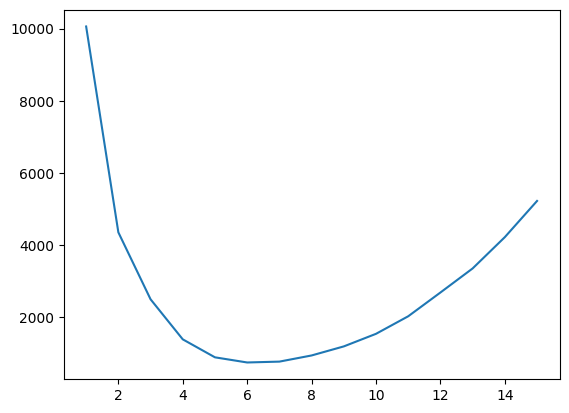

In [ ]:
#Defined in problem 4, but define again beacuse we are choosing specific values.
#L is our max depth, 15
#h_sv is our standard deviation, which we set as 60% of the sd of Y
#S is number of random errors generated. Here it is 100.
# [] for 2sigma. We are not subjecting a standard error on our model, which is why we have this empty bracket.

L           = 15
h_sv        = 0.6*np.std(Y)
S           = 100

#RRun the Tree_SURE function, with our variables as defined above.
[sure, s2_hat, df_hat] = tree_SURE(X, Y, [], L, h_sv, S)
h           = 0.6*s2_hat**(1/2)

#This J_values series is based off the fact that we have L = 15. We want to test all these possible depths, so we must iterate through them.
J_values   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

#The risk table is created, and has shape (15, 2)
risk_table = np.zeros((len(J_values),2))

#Iterate through each possible depth.
# [sure, _, _] we want to collect our SURE estimates here. We then add them into the risk table.                    
m = 0                      
for J in J_values:
    [sure, _, _] = tree_SURE(X, Y, s2_hat, J, h, S)
    risk_table[m,:] = [J, sure]
    m += 1                  

#THe risk tabkle is a simple 15 by 2 matrix. This gives us the oppurtunity to plot it.
fig = plt.figure()
ax = plt.axes()
ax.plot(risk_table[:,0], risk_table[:,1])

$----------------------------------------------------------------------$

$\text{Answer 5: }$

$\text{Answer located inside of code block, as comments}$

$----------------------------------------------------------------------$

### Question 6
Fit the regression tree that minimizes SURE. Construct a contour plot of the resulting regression surface (you may adapt the code given above). Discuss your plot and what it suggests about the relationship between earnings and schooling and age in Brazil.

$----------------------------------------------------------------------$

$\text{Answer 6: }$

$\text{We know that J=6 minimizes our risk. Using a tree of depth 6, we then form the regression surface.}$

$\text{Because we buit around regression around a decision tree, we can see that our surface is not smooth as it is the amalgamation of many binary features.} \\ \text{Generally, looking at the fact that our steps get higher and brighter as we move along the schooling axis, we can see that there are higher returns to schooling than to age.} \\ \text{} \\ \text{I originally wrote this next thing, but it is false.}$

$\text{Becuase the surface increases in both x and y directions, we can say that we have monotonicly increasing returns to both age and schooling.} \\ \text{I am unsure whether this is a function of our data, or a function of the modelling process, but I lean toward thinking it has to do with the data.}$

$\\ \text{} \\ \text{The surface is not monotonically increasing, as can be seen moving along age = 70, and going from schooling=14 to =16}$

$----------------------------------------------------------------------$

In [13]:
XY = sample[['YRSSCH','AgeInDays']]
Z = np.log(sample['MONTHLY_EARNINGS'])

In [14]:
J = 6
regr_J = tree.DecisionTreeRegressor(max_depth=J)
regr_J.fit(XY, Z)

DecisionTreeRegressor(max_depth=6)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


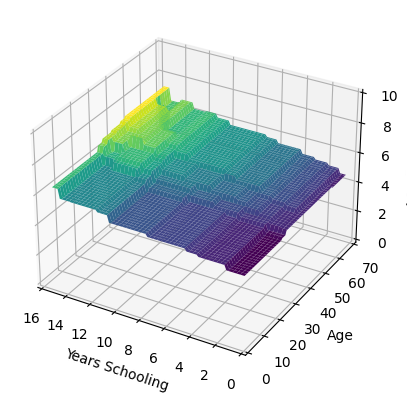

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

schooling, age = np.meshgrid(np.linspace(0, 15, 100), np.linspace(0, 65, 100))
xy = np.c_[schooling.ravel(), age.ravel()]
z = regr_J.predict(xy)
hat_log_earnings = z.reshape(schooling.shape)

ax.plot_surface(schooling, age, hat_log_earnings, cmap='viridis')

ax.set_xlabel('Years Schooling')
ax.set_ylabel('Age')
ax.set_zlabel('Log Earnings')

ax.set_xlim(16,0)
ax.set_ylim(0,70)
ax.set_zlim(0,10)

plt.show()


## Part 2: Analysis of Nicarguan data (extra credit, 5 points)
This part of the problem set will use calorie consumption data from a sample of rural households in Nicargua. We are interested in the relationship between total household outlay and calorie consumption. Understanding the nature of food demand in low income settings has important implications for understanding the prevalence of hunger and for food policy. The article by Shankar Subramanian and Angus Deaton. (1996). "The demand for food and calories," _Journal of Political Economy_ 104 (1): 133 - 162 provides a nice example of economics research in this area.

The dataset includes several years of data. We will work with X0 and Y0, which correspond to household outlay (in Cordobas) per adult equivalent and calorie consumption per adult equivalent respectively in the base year of of the survey (2000). 

In [17]:
calories = pd.read_csv(data + 'RPS_calorie_data_copy.out', header = 0)
calories['constant'] = 1
calories[['constant','X0','Y0']][0:5]

,constant,X0,Y0
0,1,8.819086,7.963177
1,1,6.889811,6.484601
2,1,6.650684,6.876681
3,1,6.909742,6.754492
4,1,8.034308,7.162158


This first block of code fits a simple linear regression model to the calorie data.

Coefficients: 
 [1.87831534 0.68778462]


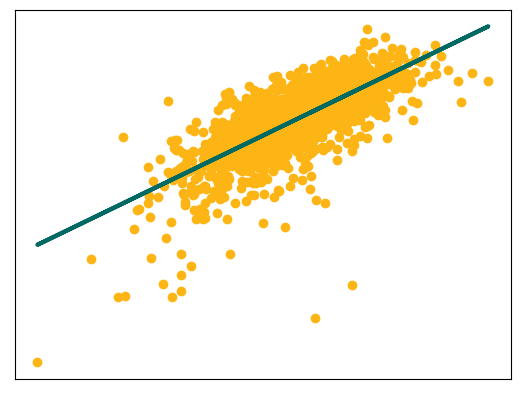

In [18]:
from sklearn import linear_model

W = calories[['constant', 'X0']]
Y = calories['Y0']

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Fir the calorie demand model
regr.fit(W, Y)

# Compute fitted values
calories_pred = regr.predict(W)

# Print out the estimated regression coefficients
print("Coefficients: \n", regr.coef_)

# Plot fitted regression model
plt.scatter(calories['X0'], calories['Y0'], color="#FDB515")
plt.plot(calories['X0'], calories_pred, color="#006962", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Question 7
For this final questions, which is a long one, you will consider alternative series approximations of the the regression function for calories given total outlay. In the example above we considered a linear model. What about a model which is quadratic in outlay? Cubic? Quartic?   

Write a function that computes the series regression of Y onto $1, X, X^2, \ldots, X^{J-1}$ by least squares. Write a second function that compute Mallows $C_J$ risk estimate. Using these functions first compute a "big" model in order to construct a good estimate of $\sigma^2$, the variance of the regression error. With this estimate in hand compute Mallows $C_J$ risk estimate for $J=1,2,3,\ldots$.   

Fit the model which minimizes estimated risk. Produce the corresponding scatter plot with the fitted curve overlayed. Discuss your results.

$----------------------------------------------------------------------$

$\text{Answer 7: }$

$\text{Create the design matrix using the np.columnstack function}$

$\text{Then use: } \hat\beta = (X^TX)^{-1} X^T Y$

$\text{Also: } \hat Y = X \hat\beta$

$\text{Calculate the: } SSR = (Y - X\hat\beta)^T(Y - X\hat\beta)$

$\text{Calculate the: } SSR = \sum(Y - \hat Y)^2$

$\text{Quoting Efron (2004), we obtain } \hat\sigma^2 \text{ from the residuals of some “big” model presumed to have negligible bias.}$

$\text{Here our `p' in } C_{p} \text{ is the number of parameters in that given model, and k is the number of parametrs in the largest model}$


$\text{For P=10, } \hat\sigma^2 = MSE_{k=10}, \text{ also, the MSE = 1/N * SSR}$

$\text{From CASI ch12.3, the section on covariance penalties, we have: } C_{p} = MSE_{p} + (2/N) \hat\sigma^2 * Tr(X(X^TX)^{-1} X^T)$

$----------------------------------------------------------------------$

In [19]:
def regression(x, y, P):
    n = len(y)
    x_design = np.column_stack([x**p for p in range(P)])
    beta_hat = np.linalg.inv(x_design.T @ x_design) @ x_design.T @ y
    return beta_hat, x_design

def MSE(x, y, P):
    n = len(y)
    beta_hat, x_design = regression(x, y, P)
    y_hat = x_design @ beta_hat
    SSR = np.sum((y - y_hat)**2)
    #SSR = ((y - (x_design @ beta_hat)) @ (calories['Y0'] - (x_design @ beta_hat)).T)
    MSE = SSR/n
    #sigma hat squared is the MSE from the "big" model.
    return MSE

def Cp(x, y, P, p_big):
    n = len(y)
    x_design = np.column_stack([x**p for p in range(P)])
    M = (x_design @ np.linalg.inv(x_design.T @ x_design) @ x_design.T)
    MSE_P = MSE(x, y, P)
    MSE_big = MSE(x, y, p_big)
    Cp = MSE_P + ((2/n) * MSE_big * M.trace())
    return Cp


In [20]:
p_big = 9
p_values = range(1, p_big) 
cp_values = [Cp(calories['X0'], calories['Y0'], p, p_big) for p in p_values]
cp_values

[0.3645463095097243,
 0.16936901156058073,
 0.16469641421869757,
 0.16615126942643502,
 0.16701340156965963,
 0.16864814512963702,
 0.17040425587447755,
 0.27315442624467745]

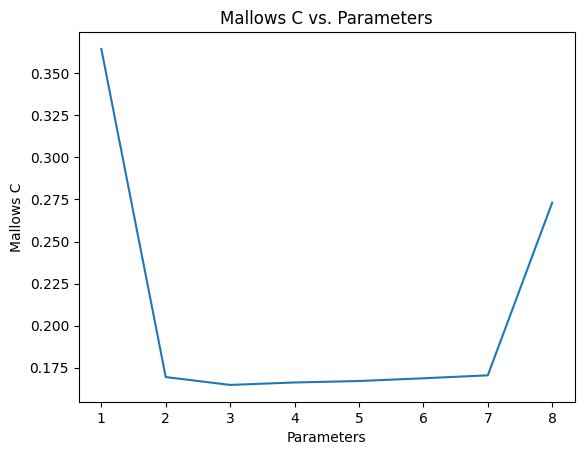

In [21]:
plt.plot(p_values, cp_values)
plt.xlabel('Parameters')
plt.ylabel('Mallows C')
plt.title('Mallows C vs. Parameters')
plt.show()


$\text{Answer 7 cont: }$

$\text{Looking at the chart, we see that 3 parametrs minimizes Mallow's C. We then run the regression on:} \\
\text{the constant, calories, and (calories)}^2$

In [55]:
regression

<function __main__.regression(x, y, P)>

Coefficients: 
 [-6.7153352   2.82620374 -0.13217263]


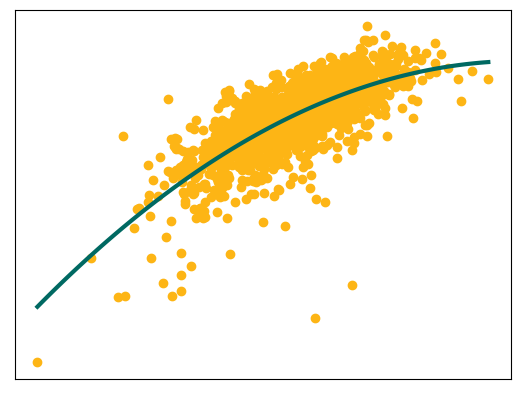

In [68]:
x = calories['X0']
W = pd.DataFrame(np.column_stack([x**p for p in range(3)]))
Y = calories['Y0']

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Fit the calorie demand model
regr.fit(W, Y)

# Compute fitted values
calories_pred = regr.predict(W)

# Print out the estimated regression coefficients
print("Coefficients: \n", regr.coef_)

# Plot fitted regression model
plt.scatter(x, calories['Y0'], color="#FDB515")

# Generate x values for the plot
x_plot = np.linspace(x.min(), x.max(), 100)

# Create the polynomial features for the plot
W_plot = pd.DataFrame(np.column_stack([x_plot**p for p in range(3)]))

# Compute the predicted values for the plot
calories_pred_plot = regr.predict(W_plot)

# Plot the quadratic curve
plt.plot(x_plot, calories_pred_plot, color="#006962", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()
